In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import time
import random
import os
import io
import logging
import numpy as np
import mxnet as mx
from mxnet import gluon,nd,autograd,npx
import gluonnlp as nlp
import nmt
from gluonnlp.model.transformer import ParallelTransformer, get_transformer_encoder_decoder
import pandas as pd 
nlp.utils.check_version('0.7.0')

In [2]:
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)
ctx = mx.gpu(0)

# parameters for dataset
dataset = 'pubchem'
src_lang, tgt_lang = 'random_smiles', 'rdkit_canonical_smiles'
src_max_len, tgt_max_len = 100, 100

# parameters for model
num_units=128
hidden_size=1024
dropout=0.05
epsilon=0.1
num_layers=3
num_heads=4
scaled=True
share_embed=True
embed_size=128
tie_weights=True
embed_initializer=None
magnitude = 3.0
lr_update_factor = 0.5
param_file = 'C:\\Users\\QI_LAB\\Desktop\\IL-PROPERTY-PREDICT-PUBCHEM\\smiles_transformer_128_1024\\valid_best.params'


In [3]:
def _load_vocab(file_path, **kwargs):
    with open(file_path, 'r') as f:
        return nlp.Vocab.from_json(f.read())

In [4]:
src_vocab = _load_vocab('C:\\Users\\QI_LAB\\Desktop\\IL-PROPERTY-PREDICT-PUBCHEM\\datasets\\pubchem\\vocab.random_smiles.json')
tgt_vocab = _load_vocab('C:\\Users\\QI_LAB\\Desktop\\IL-PROPERTY-PREDICT-PUBCHEM\\datasets\\pubchem\\vocab.rdkit_canonical_smiles.json')

In [5]:
'''
encoder1, decoder1, one_step_ahead_decoder1 = get_transformer_encoder_decoder(
    units=num_units,
    hidden_size=hidden_size,
    dropout=dropout,
    num_layers=num_layers,
    num_heads=num_heads,
    max_src_length=src_max_len,
    max_tgt_length=tgt_max_len,
    scaled=scaled, prefix='transformer_1')

encoder2, decoder2, one_step_ahead_decoder2 = get_transformer_encoder_decoder(
    units=num_units,
    hidden_size=hidden_size,
    dropout=dropout,
    num_layers=num_layers,
    num_heads=num_heads,
    max_src_length=src_max_len,
    max_tgt_length=tgt_max_len,
    scaled=scaled,prefix='transformer_2')
'''
encoder3, decoder3, one_step_ahead_decoder3 = get_transformer_encoder_decoder(
    units=num_units,
    hidden_size=hidden_size,
    dropout=dropout,
    num_layers=num_layers,
    num_heads=num_heads,
    max_src_length=src_max_len,
    max_tgt_length=tgt_max_len,
    scaled=scaled,prefix='transformer_3')
'''
model1 = nlp.model.translation.NMTModel(src_vocab=src_vocab,
                 tgt_vocab=tgt_vocab,
                 encoder=encoder1,
                 decoder=decoder1,
                 one_step_ahead_decoder=one_step_ahead_decoder1,
                 embed_size=num_units,
                 embed_initializer=None,
                 prefix='transformer_1')
model2 = nlp.model.translation.NMTModel(src_vocab=src_vocab,
                 tgt_vocab=tgt_vocab,
                 encoder=encoder2,
                 decoder=decoder2,
                 one_step_ahead_decoder=one_step_ahead_decoder2,
                 embed_size=num_units,
                 embed_initializer=None,
                 prefix='transformer_2')
'''
model3 = nlp.model.translation.NMTModel(src_vocab=src_vocab,
                 tgt_vocab=tgt_vocab,
                 encoder=encoder3,
                 decoder=decoder3,
                 one_step_ahead_decoder=one_step_ahead_decoder3,
                 embed_size=num_units,
                 embed_initializer=None,
                 prefix='transformer_3')

In [6]:
#model.initialize(init=mx.init.Xavier(magnitude=magnitude), ctx=ctx)

In [7]:
#model1.load_parameters(param_file,ctx=ctx)
#model2.load_parameters(param_file,ctx=ctx)
model3.load_parameters(param_file,ctx=ctx)

model.hybridize()

def encode(model, src_seq, src_vocab,ctx):
    src_sentence = src_vocab[src_seq.split()]
    src_sentence.append(src_vocab[src_vocab.eos_token])
    src_npy = np.array(src_sentence, dtype=np.int32)
    src_nd = mx.nd.array(src_npy)
    src_nd = src_nd.reshape((1, -1)).as_in_context(ctx)
    src_valid_length = mx.nd.array([src_nd.shape[1]]).as_in_context(ctx)
    enc_outputs = model.encode(src_nd,valid_length=src_valid_length)
    return enc_outputs

for sentence in ['c 1 ( N = C ( N ) N ) s c c ( - c 2 c c ( C ) n ( C ) c 2 ) n 1', 'C ( C ( c 1 c c c ( C ( N O ) = O ) c c 1 ) C C ) C']:
    e = encode(model, sentence,src_vocab,ctx)
    print(e)

In [8]:
from rdkit import Chem
def canonical_smile(sml):
    try:
        m = Chem.MolFromSmiles(sml)
        #return Chem.MolToSmiles(m, canonical=True,isomericSmiles=False)
        return Chem.MolToSmiles(m, canonical=True,isomericSmiles=True)
    except:
        print(sml)
        return float('nan')

In [9]:
def no_split(sm):
    arr = []
    i = 0
    try:
        len(sm)
    except:
        print(sm)
    while i < len(sm)-1:
        arr.append(sm[i])
        i += 1
    if i == len(sm)-1:
        arr.append(sm[i])
    return ' '.join(arr)

In [10]:
length_clip = nlp.data.ClipSequence(100)
# Helper function to preprocess a single data point
def preprocess(data):
    # A token index or a list of token indices is
    # returned according to the vocabulary.
    src_sentence = src_vocab[length_clip(data.split())]
    src_sentence.append(src_vocab[src_vocab.eos_token])
    src_npy = np.array(src_sentence, dtype=np.int32)
    src_nd = mx.nd.array(src_npy)
    return src_nd

# Helper function for getting the length
def get_length(x):
    return float(len(x.split(' ')))

In [11]:
dropout = 0.05
train_batch_size = 128
test_batch_size = 64

In [12]:
class ILNet(gluon.HybridBlock):
    """Network for sentiment analysis."""
    def __init__(self,
                 dropout,
                 src_vocab=src_vocab,
                 embed_size=embed_size,
                 output_size=1,
                 num_filters=(100, 200, 200, 200, 200, 100,100),
                 ngram_filter_sizes=(1, 2, 3, 4, 5, 6,7),
                 IL_num_filters=(100, 200, 200, 200, 200, 100, 100, 100, 100,100, 160, 160),
                 IL_ngram_filter_sizes=(1, 2, 3,4, 5, 6, 7, 8, 9, 10, 15, 20),
                 prefix=None,
                 params=None):
        super(ILNet, self).__init__(prefix=prefix, params=params)
        with self.name_scope():
            
            self.num_filters = num_filters
            self.IL_num_filters = IL_num_filters
            '''
            self.cation_src_embed = None
            self.cation_encoder = None
            self.cation_textcnn = nlp.model.ConvolutionalEncoder(
                embed_size=embed_size,
                num_filters=num_filters,
                ngram_filter_sizes=ngram_filter_sizes,
                conv_layer_activation='relu',
                num_highway=1)
            self.cation_dropout = gluon.nn.Dropout(dropout)

            self.anion_src_embed = None
            self.anion_encoder = None
            self.anion_textcnn = nlp.model.ConvolutionalEncoder(
                embed_size=embed_size,
                num_filters=num_filters,
                ngram_filter_sizes=ngram_filter_sizes,
                conv_layer_activation='relu',
                num_highway=1)
            self.anion_dropuot = gluon.nn.Dropout(dropout)
            '''
            self.IL_src_embed = None
            self.IL_encoder = None
            self.IL_textcnn = nlp.model.ConvolutionalEncoder(
                embed_size=embed_size,
                num_filters=IL_num_filters,
                ngram_filter_sizes=IL_ngram_filter_sizes,
                conv_layer_activation='relu',
                num_highway=1)
            #self.IL_dropout = gluon.nn.Dropout(dropout)
            '''
            self.mlp = gluon.nn.HybridSequential()
            with self.mlp.name_scope():
                #self.mlp.add(gluon.nn.Dropout(dropout))
                self.mlp.add(gluon.nn.Dense(1024))
                #self.mlp.add(gluon.nn.BatchNorm())
                self.mlp.add(gluon.nn.Activation('relu'))
                #self.mlp.add(gluon.nn.Dropout(dropout))
                
                self.mlp.add(gluon.nn.Dense(2048))
                self.mlp.add(gluon.nn.BatchNorm())
                self.mlp.add(gluon.nn.Activation('relu'))
                
                self.mlp.add(gluon.nn.Dense(1024))
                self.mlp.add(gluon.nn.BatchNorm())
                self.mlp.add(gluon.nn.Activation('relu'))
                
                self.mlp.add(gluon.nn.Dense(512))
                self.mlp.add(gluon.nn.BatchNorm())
                self.mlp.add(gluon.nn.Activation('relu'))
                self.mlp.add(gluon.nn.Dense(256))
                self.mlp.add(gluon.nn.BatchNorm())
                self.mlp.add(gluon.nn.Activation('relu'))
                '''
            self.output = gluon.nn.HybridSequential()
            with self.output.name_scope():
                #self.output.add(gluon.nn.Dropout(dropout))
                self.output.add(gluon.nn.Dense(1024))
                self.output.add(gluon.nn.Activation('relu'))
                self.output.add(gluon.nn.Dropout(dropout))
                self.output.add(gluon.nn.Dense(512))
                self.output.add(gluon.nn.Activation('relu'))
                '''
                #self.output.add(gluon.nn.Dropout(dropout))
                self.output.add(gluon.nn.Dense(512))
                self.output.add(gluon.nn.Activation('relu'))
                #self.output.add(gluon.nn.Dropout(dropout))
                self.output.add(gluon.nn.Dense(256))
                self.output.add(gluon.nn.Activation('relu'))
                #self.output.add(gluon.nn.Dropout(dropout))
                '''
                self.output.add(gluon.nn.Dense(output_size, flatten=False))

    def hybrid_forward(self, F, IL_src_nd, IL_valid_length, T, P):  # pylint: disable=arguments-differ
        '''
        cation_src_embed_ = self.cation_src_embed(cation_src_nd)
        cation_encoded, _ = self.cation_encoder(
            cation_src_embed_,
            valid_length=cation_valid_length)  # Shape(T, N, C)
        cation_textcnn = self.cation_textcnn(
            F.transpose(cation_encoded, axes=(1, 0, 2)))
        cation_textcnn = self.cation_dropout(cation_textcnn)

        anion_src_embed_ = self.anion_src_embed(anion_src_nd)
        anion_encoded, _ = self.anion_encoder(
            anion_src_embed_,
            valid_length=anion_valid_length)  # Shape(T, N, C)
        anion_textcnn = self.anion_textcnn(
            F.transpose(anion_encoded, axes=(1, 0, 2)))
        anion_textcnn = self.anion_dropuot(anion_textcnn)
        '''
        IL_src_embed_ = self.IL_src_embed(IL_src_nd)
        IL_encoded, _ = self.IL_encoder(
            IL_src_embed_,
            valid_length=IL_valid_length)  # Shape(T, N, C)
        IL_textcnn = self.IL_textcnn(
            F.transpose(IL_encoded, axes=(1, 0, 2)))
        #IL_textcnn = self.IL_dropout(IL_textcnn)
        
        T_ = F.reshape(T, shape=(-1, 1))
        P_ = F.reshape(P, shape=(-1, 1))
        
        input_vecs = mx.symbol.concat(
            F.reshape(IL_textcnn,
                      shape=(-1, sum(self.IL_num_filters))),T_, P_)
        
        #mlp_out = self.mlp(IL_textcnn)

        

        #add_temp_press = mx.symbol.concat(IL_textcnn, T_, P_)
        out = self.output(input_vecs)
        return out

In [13]:
net = ILNet(dropout=dropout)
#net.cation_encoder = model1.encoder
#net.cation_src_embed =  model1.src_embed

#net.anion_encoder = model2.encoder
#net.anion_src_embed =  model2.src_embed

net.IL_encoder = model3.encoder
net.IL_src_embed =  model3.src_embed
net.hybridize()
print(net)
#net.textcnn.initialize(mx.init.Xavier(), ctx=ctx)
#net.output.initialize(mx.init.Xavier(), ctx=ctx)

ILNet(
  (IL_src_embed): HybridSequential(
    (0): Embedding(72 -> 128, float32)
    (1): Dropout(p = 0.0, axes=())
  )
  (IL_encoder): TransformerEncoder(
    (dropout_layer): Dropout(p = 0.05, axes=())
    (layer_norm): LayerNorm(eps=1e-05, axis=-1, center=True, scale=True, in_channels=128)
    (transformer_cells): HybridSequential(
      (0): TransformerEncoderCell(
        (dropout_layer): Dropout(p = 0.05, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.05, axes=())
          )
          (proj_query): Dense(128 -> 128, linear)
          (proj_key): Dense(128 -> 128, linear)
          (proj_value): Dense(128 -> 128, linear)
        )
        (proj): Dense(128 -> 128, linear)
        (ffn): PositionwiseFFN(
          (ffn_1): Dense(128 -> 1024, linear)
          (activation): Activation(relu)
          (ffn_2): Dense(1024 -> 128, linear)
          (dropout_layer): Dropout(p = 0.0

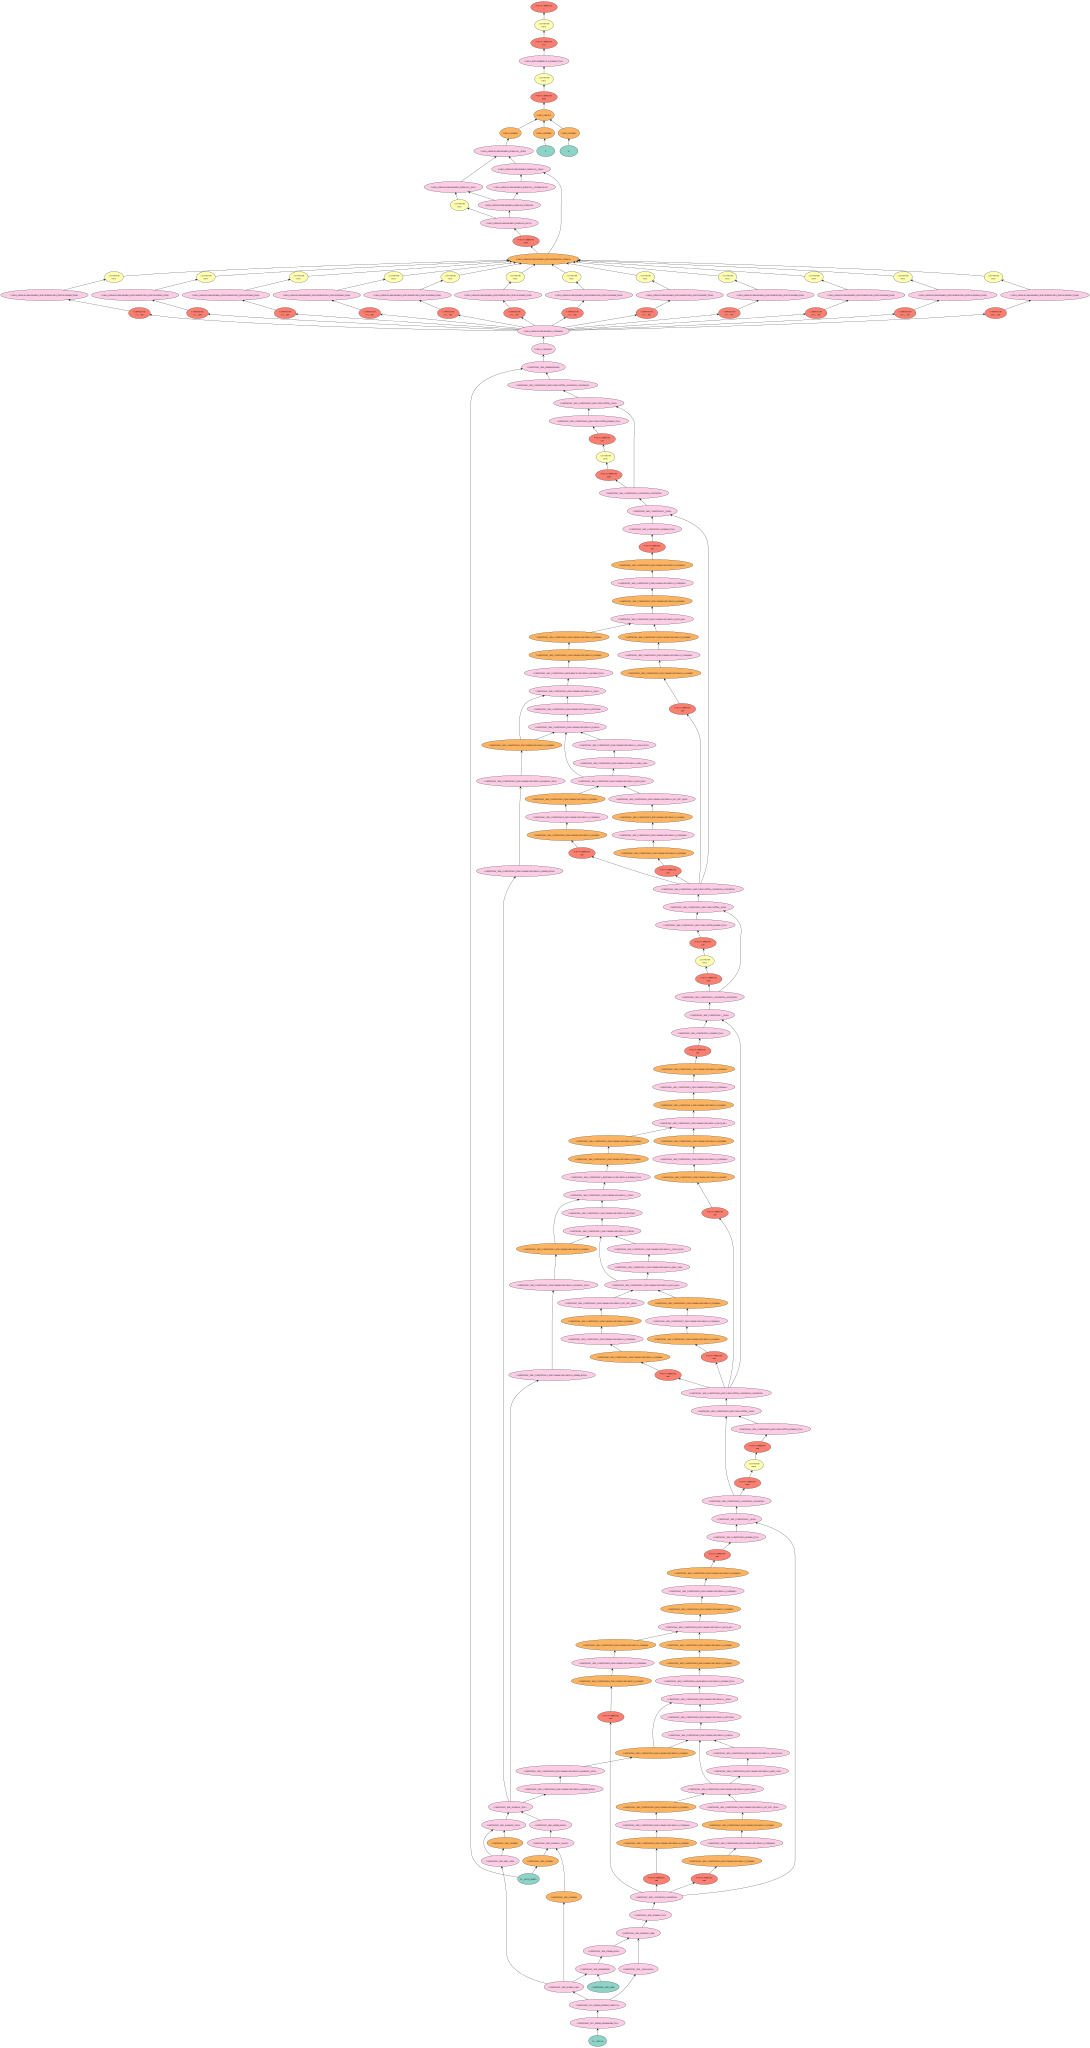

In [14]:
mx.viz.plot_network(net(mx.sym.var('IL_smiles'),mx.sym.var('IL_valid_length'),mx.sym.var('T'),mx.sym.var('P'))[0],
                    node_attrs={
                        "shape": "oval",
                        "fixedsize": "false"
                    })

In [15]:
from sklearn import metrics

def get_r2(label, pred, multioutput='uniform_average'):
    label = label.asnumpy()
    pred = pred.asnumpy()
    r2 = metrics.r2_score(label,pred,multioutput=multioutput)
    return r2

In [16]:
home_dir = 'C:\\Users\\QI_LAB\\Desktop\\IL-PROPERTY-PREDICT-PUBCHEM\\density'
save_dir = os.path.join(home_dir,'textcnn')

def train(net, train_data, batch_size, learning_rate, context, epochs,log_interval=10, dev_data=None, fold=None ):
    start_pipeline_time = time.time()
    #net.cation_textcnn.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    #net.anion_textcnn.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    net.IL_textcnn.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    #net.IL_dropout.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    #net.mlp.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    net.output.initialize(mx.init.Xavier(), ctx=context, force_reinit=True)
    num_epoch_lr = 10
    factor = 0.5
    schedule = mx.lr_scheduler.FactorScheduler(base_lr = learning_rate, step=len(train_data)* num_epoch_lr,factor=factor)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'lr_scheduler': schedule})
    #trainer = gluon.Trainer(net.collect_params(), 'adam',{'learning_rate': learning_rate})
    loss = gluon.loss.L2Loss()
    # Training/Testing.
    best_epoch_L = 10000
    for epoch in range(epochs):
        # Epoch training stats.
        start_epoch_time = time.time()
        epoch_L = 0.0
        epoch_r2 = 0.0
        epoch_sent_num = 0
        r2_num = 0
        epoch_wc = 0
        # Log interval training stats.
        start_log_interval_time = time.time()
        log_interval_wc = 0
        log_interval_sent_num = 0
        log_interval_L = 0.0
        for i, ((IL_data, IL_length), T,P,label) in enumerate(train_data):
            #cation_data = cation_data.as_in_context(context)
            #cation_length = cation_length.as_in_context(context).astype(np.float32)
            #anion_data = anion_data.as_in_context(context)
            #anion_length = anion_length.as_in_context(context).astype(np.float32)
            IL_data = IL_data.as_in_context(context)
            IL_length = IL_length.as_in_context(context).astype(np.float32)
            T = T.as_in_context(context)
            P = P.as_in_context(context)
            label = label.as_in_context(context)
            wc = max_len
            log_interval_wc += wc
            epoch_wc += wc
            log_interval_sent_num += label.shape[0]
            epoch_sent_num += label.shape[0]
            with autograd.record():
                output = net(IL_data, IL_length,T,P)
                L = loss(output, label).sum()
                r2 = get_r2(output,label)
            L.backward()
            # Update parameter.
            trainer.step(batch_size)
            log_interval_L += L.asscalar()
            epoch_L += L.asscalar()
            epoch_r2+=r2
            r2_num+=1
            if (i + 1) % log_interval == 0:
                print('[Epoch %d Batch %d/%d] avg loss %g, throughput %gK wps' % (
                    epoch, i + 1, len(train_data),
                    log_interval_L / log_interval_sent_num,
                    log_interval_wc / 1000 / (time.time() - start_log_interval_time)))
                # Clear log interval training stats.
                start_log_interval_time = time.time()
                log_interval_wc = 0
                log_interval_sent_num = 0
                log_interval_L = 0
        end_epoch_time = time.time()
        
        if  (epoch_L/ epoch_sent_num) < best_epoch_L:
            best_epoch_L = epoch_L
            save_path = os.path.join(save_dir, 'density_best.params')
            net.save_parameters(save_path)
         
        
        print('[Epoch %d] train avg loss %g, train avg r2 %g,'
              'throughput %gK wps' % (
                  epoch, epoch_L / epoch_sent_num, epoch_r2 / r2_num,
                  epoch_wc / 1000 / (end_epoch_time - start_epoch_time)))
        print('learning rate:',trainer.learning_rate)
        '''
        if epoch + 1 >= (epochs * 2) // 3:
            new_lr = trainer.learning_rate * lr_update_factor
            trainer.set_learning_rate(new_lr)
        '''
    print('Total time cost %.2fs'%(time.time()-start_pipeline_time))
    return epoch_L / epoch_sent_num, epoch_r2 / r2_num

In [17]:
def get_dataloader(train_dataset):

    # Pad data, stack label and lengths
    batchify_fn = nlp.data.batchify.Tuple(
        nlp.data.batchify.Pad(axis=0, pad_val=0, ret_length=True),
        nlp.data.batchify.Stack(dtype='float32'),nlp.data.batchify.Stack(dtype='float32'),nlp.data.batchify.Stack(dtype='float32'))

    
    # Construct a DataLoader object for both the training and test data
    train_dataloader = gluon.data.DataLoader(dataset=train_dataset,
                                             batchify_fn=batchify_fn,batch_size = train_batch_size)

    return train_dataloader

In [18]:
density_database = pd.read_excel('density_P.xlsx',sheet_name='raw')

In [19]:
train_IL_smiles = density_database['IL SMILES'].map(canonical_smile).map(no_split).map(preprocess)
train_T =density_database['normalized_T']
train_P = density_database['normalized_P']
train_lngamma = density_database['ρ / kg/m3']
train_dataset = gluon.data.SimpleDataset(gluon.data.ArrayDataset(train_IL_smiles,train_T,train_P,train_lngamma))
train_dataloader = get_dataloader(train_dataset)

In [20]:
epochs, learning_rate = 160,0.001                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
max_len = 100
train(net, train_dataloader, train_batch_size, learning_rate, ctx, epochs)
#train(net, train_dataloader, test_dataloader, batch_size, learning_rate, ctx, epochs)

[Epoch 0 Batch 10/244] avg loss 638257, throughput 0.0102184K wps
[Epoch 0 Batch 20/244] avg loss 50728.3, throughput 0.0198441K wps
[Epoch 0 Batch 30/244] avg loss 15263, throughput 0.0403185K wps
[Epoch 0 Batch 40/244] avg loss 8304.63, throughput 0.128238K wps
[Epoch 0 Batch 50/244] avg loss 6411.53, throughput 0.138985K wps
[Epoch 0 Batch 60/244] avg loss 19966.6, throughput 0.0123562K wps
[Epoch 0 Batch 70/244] avg loss 24472.6, throughput 0.0183493K wps
[Epoch 0 Batch 80/244] avg loss 10771.8, throughput 0.0582954K wps
[Epoch 0 Batch 90/244] avg loss 14458.4, throughput 0.0173379K wps
[Epoch 0 Batch 100/244] avg loss 22359.6, throughput 0.323311K wps
[Epoch 0 Batch 110/244] avg loss 13891.9, throughput 0.0472768K wps
[Epoch 0 Batch 120/244] avg loss 33820.1, throughput 0.0577701K wps
[Epoch 0 Batch 130/244] avg loss 15060.5, throughput 0.0478675K wps
[Epoch 0 Batch 140/244] avg loss 7141.02, throughput 0.0559315K wps
[Epoch 0 Batch 150/244] avg loss 12796.7, throughput 0.0279728K

(294.6120919349292, 0.8156604007943504)